In [16]:
# === 1. Import libraries ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [17]:
# === 2. Load dataset ===
df = pd.read_csv('../data/final/final_dataset.csv')
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (72008, 108)


,gameId,home_gameDate,home_teamCity,home_teamName,home_teamId,home_opponentTeamCity,home_opponentTeamName,home_opponentTeamId,home_home,home_win_x,...,diff_rebounds,diff_fg_pct,diff_3p_pct,diff_ft_pct,diff_turnovers,diff_steals,diff_blocks,home_win_y,score_diff,gameType
0,22500127,2025-10-28T23:00:00Z,Golden State,Warriors,1610612744,LA,Clippers,1610612746,1,1,...,-5.0,0.087,0.196,-0.063,0.0,4.0,1.0,1,19,NaN
1,22500125,2025-10-28T20:00:00Z,Milwaukee,Bucks,1610612749,New York,Knicks,1610612752,1,1,...,-7.0,0.120,0.087,0.005,0.0,-2.0,6.0,1,10,NaN
2,22500126,2025-10-28T20:00:00Z,Oklahoma City,Thunder,1610612760,Sacramento,Kings,1610612758,1,1,...,-2.0,0.033,-0.027,-0.005,2.0,0.0,7.0,1,6,NaN
3,22500124,2025-10-28T19:30:00Z,Miami,Heat,1610612748,Charlotte,Hornets,1610612766,1,1,...,-4.0,0.098,0.044,0.083,6.0,-1.0,-1.0,1,27,NaN
4,22500123,2025-10-28T19:00:00Z,Washington,Wizards,1610612764,Philadelphia,76ers,1610612755,1,0,...,-5.0,0.027,-0.010,-0.151,-1.0,3.0,-6.0,0,-5,NaN


In [ ]:
# === 3. Ensure target column exists ===
# If 'home_win' column is missing, recreate it using team scores
if 'home_win' not in df.columns:
    if 'home_teamScore' in df.columns and 'away_teamScore' in df.columns:
        df['home_win'] = (df['home_teamScore'] > df['away_teamScore']).astype(int)
        print("✅ Target column 'home_win' created from score difference.")
    else:
        raise ValueError("Missing both 'home_teamScore' and 'away_teamScore' — cannot compute target.")
    

✅ Target column 'home_win' created from score difference.


In [19]:
# === 4. Define target and features ===

# Target variable
y = df['home_win']

# Drop non-predictive or identifier columns
drop_cols = [col for col in ['home_win', 'score_diff', 'gameId'] if col in df.columns]
X = df.drop(columns=drop_cols)

# Keep only numeric columns for model training
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

print(f"✅ Numeric features selected: {X.shape[1]} columns")
print(f"Training samples: {X.shape[0]}")

# Optional: show non-numeric columns dropped
non_numeric_cols = df.drop(columns=drop_cols).select_dtypes(exclude=['int64', 'float64', 'bool']).columns.tolist()
print("Dropped non-numeric columns:", non_numeric_cols[:10], "..." if len(non_numeric_cols) > 10 else "")

✅ Numeric features selected: 95 columns
Training samples: 72008
Dropped non-numeric columns: ['home_gameDate', 'home_teamCity', 'home_teamName', 'home_opponentTeamCity', 'home_opponentTeamName', 'away_gameDate', 'away_teamCity', 'away_teamName', 'away_opponentTeamCity', 'away_opponentTeamName'] ...


In [ ]:
# === 5. Split train/test sets ===
# Remove data leakage columns (post-game info)
leakage_cols = [col for col in X.columns if 'win' in col.lower() or 'plusMinus' in col or 'diff_points' in col]
print("Removing potential leakage columns:", leakage_cols)

X = X.drop(columns=leakage_cols, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Removing potential leakage columns: ['home_win_x', 'home_plusMinusPoints', 'home_seasonWins', 'away_win', 'away_plusMinusPoints', 'away_seasonWins', 'diff_points', 'home_win_y']
Train size: (57606, 87), Test size: (14402, 87)


In [21]:
# === 6. Train Random Forest model ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [22]:
# === 7. Evaluate model ===
print("\n📊 Model Performance")
print("-------------------")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


📊 Model Performance
-------------------
Accuracy: 0.9601

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      4862
           1       0.95      0.99      0.97      9540

    accuracy                           0.96     14402
   macro avg       0.97      0.94      0.95     14402
weighted avg       0.96      0.96      0.96     14402



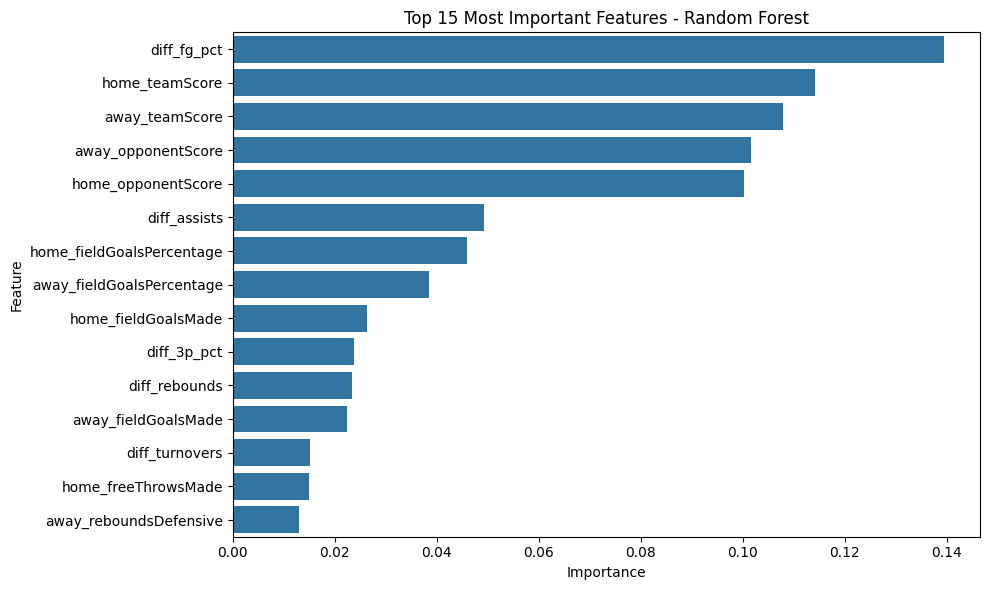

In [23]:
# === 8. Feature importance visualization ===
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances[:15], y=feat_importances.index[:15])
plt.title("Top 15 Most Important Features - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [26]:
# === 9. Save model ===
import os

# Ensure final directory exists
os.makedirs('../data/final', exist_ok=True)

# Save trained model
joblib.dump(rf_model, '../data/final/nba_rf_model.pkl')
print("💾 Model saved successfully as 'nba_rf_model.pkl'")

# === 10. Save final dataset (with home_win) ===
if 'home_win' not in df.columns:
    if 'home_teamScore' in df.columns and 'away_teamScore' in df.columns:
        df['home_win'] = (df['home_teamScore'] > df['away_teamScore']).astype(int)
        print("✅ 'home_win' column created from score difference.")
    else:
        raise ValueError("Missing both 'home_teamScore' and 'away_teamScore' — cannot create target variable.")

df.to_csv('../data/final/final_dataset.csv', index=False)
print(f"💾 Final dataset saved with shape {df.shape} and 'home_win' included.")

💾 Model saved successfully as 'nba_rf_model.pkl'
💾 Final dataset saved with shape (72008, 109) and 'home_win' included.


In [27]:
# === 10. Predict win probabilities (optional) ===
proba = rf_model.predict_proba(X_test)[:, 1]
print("\nPredicted win probabilities (first 10):")
print(np.round(proba[:10], 3))


Predicted win probabilities (first 10):
[0.203 0.914 0.928 0.811 0.42  0.825 0.123 0.48  0.336 0.773]
